[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Skrikunov/PAPR_reduction/blob/master/PAPR.ipynb)


# Imports

In [31]:
!which jupyter # check current environment
reload = [False,True][0]
if reload: 
    !lsof /dev/nvidia* | awk '{print $2}' | xargs -I {} kill {}

/home/stas/anaconda3/envs/myenv/bin/jupyter


In [32]:
# EXTERNAL LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import yaml
from pathlib import Path
import os
import sys

# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
    print('You are going to use GOOGLE COLAB')
except ImportError:
    IN_COLAB = False
    print('You are going to use LOCAL MACHINE')

# Add path for scripts and files directory
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    AUX_DATA_ROOT = Path("/content/drive/My Drive/PAPR reduction/Code")
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    sys.path.append(str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = ''
          
if torch.cuda.is_available():
    device=torch.device('cuda')
    print('You are going to use CUDA')
else:
    device=torch.device('cpu')
    print('You are going to use CPU')
    
# MY SCRIPTS
sys.path.append('functions/') # scripts folder
import plots
import system as syst
import qammod as qmd
import papreduce as prd
import ccdf as ccdf
import file as f
import my
    
%load_ext autoreload
%autoreload 2

You are going to use LOCAL MACHINE
You are going to use CUDA
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load system's configuration

In [86]:
# OPEN CONFIGURATION FILE
with open('config.yaml','r') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)
    print('* Config has been read successfully:')

# edit configuration
# cfg['Fs'] = 15.36
cfg['N_UE'] = 6
# cfg['P_UE_max_min'] = 100
# cfg['N_fft'] = 300
# cfg['N_used'] = 120
# cfg['N_zero'] = 180
# cfg['N_RB'] = 10
cfg['M'] = 1000
# cfg['N_SC_RB'] = 12

USE_SEED = False
if not USE_SEED:
    cfg['RNG_SEED'] = cfg['P_SEED'] = cfg['M_SEED'] = cfg['RB_SEED'] = None
else:
    cfg['RNG_SEED'], cfg['P_SEED'], cfg['M_SEED'], cfg['RB_SEED'] = 0,1,2,3
# show system's configuration
display(cfg)

# load complex and decimal modulation constellations
constellations = qmd.load_constellations(config=cfg,device=device,info=True)

# load Fourier matrix
S_sc = prd.gen_fourier_matrix(config=cfg,device=device)

# PAPR range for CCDF
PAPR_RANGE = torch.arange(0,12.2,step=0.2)

# zero shift to center spectrum
ZERO_SHIFT = cfg['N_zero']//2

CCDF_SIZE = (8,8)
PSD_SIZE = (8,8)

* Config has been read successfully:


{'Fs': 15.36,
 'N_UE': 6,
 'P_UE_max_min': 100,
 'P_TX': 100,
 'N_fft': 1024,
 'N_used': 600,
 'N_zero': 424,
 'N_RB': 50,
 'EVM_QPSK': 17.5,
 'EVM_QAM16': 12.5,
 'EVM_QAM64': 8,
 'EVM_QAM256': 3.5,
 'EVM_QAM1024': 1,
 'M': 1000,
 'N_SC_RB': 12,
 'RNG_SEED': None,
 'P_SEED': None,
 'M_SEED': None,
 'RB_SEED': None}

The following constelletions have been loaded: ['QPSK', 'QAM16', 'QAM64', 'QAM256', 'QAM1024']


# Power allocation
# Modulation type allocation, EVM allocation
# Allowed noise level allocation(calculation)
# Resourse block allocation

In [87]:
PTX_allocation = syst.PTX_allocate(config=cfg,info=True)
# PTX_allocation = 100*np.ones(cfg['N_UE'])/cfg['N_UE']

MOD_allocation,EVM_allocation = syst.MOD_allocate(config=cfg,info=True)
ANL_allocation,_ = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=True)
RB_allocation = syst.RB_allocate(config=cfg,info=True)
# RB_allocation = (50*np.ones(cfg['N_UE'])/cfg['N_UE']).astype(int)

UE_IDXs = np.arange(cfg['N_UE'])
UE_ANLs = ANL_allocation
UE_SCs = [syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=np.array([i]),RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT for i in UE_IDXs]
SCs = syst.GET_UE_SC_idx(torch.tensor(RB_allocation))+ZERO_SHIFT

* UE power has been allocated - OK:
Max UE power can be:     95.238
Min UE power can be:      0.952
Sum UE power can be:    100.000
Current Ptx allocation: [26. 21.  4. 11. 18. 20.] Sum = 100.000

* MODs have been allocated - OK:
Current MODs allocation: ['QAM64', 'QAM1024', 'QAM16', 'QPSK', 'QAM256', 'QPSK']
Current EVMs allocation: [ 8.   1.  12.5 17.5  3.5 17.5]

Allowed noise level allocation: [-27.788 -46.778 -32.041 -24.725 -36.566 -22.129] dB
                                [4.079 0.458 2.5   5.804 1.485 7.826] %

* RBs have been allocated - OK:
Current RB allocation: [12  9  8  6  3 12] Sum = 50



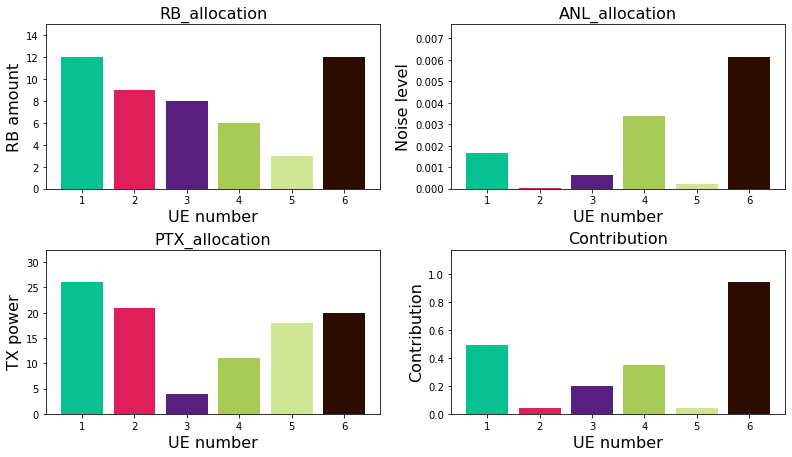

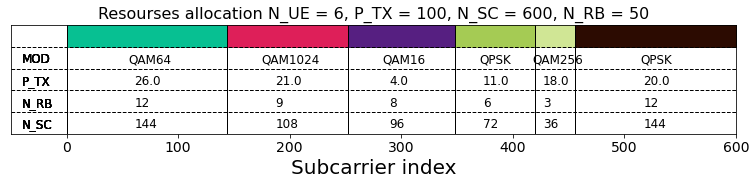

In [88]:
color_list = plots.plot_allocations(RB_allocation,PTX_allocation,ANL_allocation)
plots.plot_res_allocation(np.array(PTX_allocation),np.array(RB_allocation),MOD_allocation,color_list,cfg)

# Find optimal split theoretically
## combinations

In [89]:
from my import opt_split_theor
g_num = 3
split_best,idx_best,result = opt_split_theor(g_num,ANL_allocation,RB_allocation)

0) [array([5, 3, 0, 2, 4, 1])] 0.229
1) [array([5]), array([3, 0, 2, 4, 1])] 1.113
2) [array([5, 3]), array([0, 2, 4, 1])] 1.191
3) [array([5, 3, 0]), array([2, 4, 1])] 1.315
4) [array([5, 3, 0, 2]), array([4, 1])] 1.005
5) [array([5, 3, 0, 2, 4]), array([1])] 0.65
6) [array([5]), array([3]), array([0, 2, 4, 1])] 1.434
7) [array([5]), array([3, 0]), array([2, 4, 1])] 1.765
8) [array([5]), array([3, 0, 2]), array([4, 1])] 1.644
9) [array([5]), array([3, 0, 2, 4]), array([1])] 1.411
10) [array([5, 3]), array([0]), array([2, 4, 1])] 1.626
11) [array([5, 3]), array([0, 2]), array([4, 1])] 1.6
12) [array([5, 3]), array([0, 2, 4]), array([1])] 1.428
13) [array([5, 3, 0]), array([2]), array([4, 1])] 1.479
14) [array([5, 3, 0]), array([2, 4]), array([1])] 1.428
15) [array([5, 3, 0, 2]), array([4]), array([1])] 1.036
BEST SPLIT: N = 7,[array([5]), array([3, 0]), array([2, 4, 1])],result = 1.765


# k-means

In [90]:
from my import kmeans_split

split_best = kmeans_split(ANL_allocation,n_clusters=g_num)

BEST SPLIT (KMEANS): [array([5]), array([3]), array([0, 1, 2, 4])]


# Test reduction with different thresholds

In [91]:
# generate test signal
torch.cuda.ipc_collect()
torch.cuda.empty_cache() # generate data points
D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False) # modulate them
S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=False)

In [92]:
from my import test_reduction

peak_ths = [7,8,9]
S_t_reduced = test_reduction(S_t,split_best,peak_ths,UE_ANLs,UE_SCs,S_sc,cfg,info=True)
peak_ths = [9]*3
S_t_reduced = test_reduction(S_t,split_best,peak_ths,UE_ANLs,UE_SCs,S_sc,cfg,info=True)

MAX PAPR before: 11.261
MAX PAPR after:  10.125
multiple thresholds
Thresholds: [7, 8, 9]
Sequential(
  (layer_0): reduction_layer(peak_th=7.000,group_ANL_th=0.006125)
  (layer_1): reduction_layer(peak_th=8.000,group_ANL_th=0.003369)
  (layer_2): reduction_layer(peak_th=9.000,group_ANL_th=0.000021)
)
MAX PAPR before: 11.261
MAX PAPR after:  9.581
multiple thresholds
Thresholds: [9, 9, 9]
Sequential(
  (layer_0): reduction_layer(peak_th=9.000,group_ANL_th=0.006125)
  (layer_1): reduction_layer(peak_th=9.000,group_ANL_th=0.003369)
  (layer_2): reduction_layer(peak_th=9.000,group_ANL_th=0.000021)
)


# Find optimal split practically

In [93]:
from my import opt_split_pract
split_best,idx_best,max_papr_best = opt_split_pract(S_t,ANL_allocation,UE_ANLs,UE_SCs,S_sc,cfg)

0) [array([5, 3, 0, 2, 4, 1])] 10.996
1) [array([5]), array([3, 0, 2, 4, 1])] 10.016
2) [array([5, 3]), array([0, 2, 4, 1])] 9.847
3) [array([5, 3, 0]), array([2, 4, 1])] 9.607
4) [array([5, 3, 0, 2]), array([4, 1])] 10.027
5) [array([5, 3, 0, 2, 4]), array([1])] 10.486
6) [array([5]), array([3]), array([0, 2, 4, 1])] 9.581
7) [array([5]), array([3, 0]), array([2, 4, 1])] 9.118
8) [array([5]), array([3, 0, 2]), array([4, 1])] 9.285
9) [array([5]), array([3, 0, 2, 4]), array([1])] 9.613
10) [array([5, 3]), array([0]), array([2, 4, 1])] 9.25
11) [array([5, 3]), array([0, 2]), array([4, 1])] 9.279
12) [array([5, 3]), array([0, 2, 4]), array([1])] 9.522
13) [array([5, 3, 0]), array([2]), array([4, 1])] 9.376
14) [array([5, 3, 0]), array([2, 4]), array([1])] 9.45
15) [array([5, 3, 0, 2]), array([4]), array([1])] 9.987
BEST SPLIT: N = 7,[array([5]), array([3, 0]), array([2, 4, 1])],result = 9.118


# Find a single optimal threshold

PAPR after reduction:9.118, best threshold: 8.918



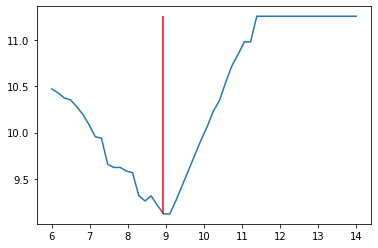

In [94]:
from my import single_opt_th
th_range = np.linspace(6,14,50)
best_th = single_opt_th(S_t,th_range,split_best,UE_ANLs,UE_SCs,S_sc,cfg,info=True)

In [95]:
peak_ths = [best_th]*3
S_t_reduced =  test_reduction(S_t,split_best,peak_ths,UE_ANLs,UE_SCs,S_sc,cfg,info=True)

MAX PAPR before: 11.261
MAX PAPR after:  9.118
multiple thresholds
Thresholds: [8.91796875, 8.91796875, 8.91796875]
Sequential(
  (layer_0): reduction_layer(peak_th=8.918,group_ANL_th=0.006125)
  (layer_1): reduction_layer(peak_th=8.918,group_ANL_th=0.001664)
  (layer_2): reduction_layer(peak_th=8.918,group_ANL_th=0.000021)
)


In [96]:
# from my import find_opt_th

# split = split_best[2]
# best_th = find_opt_th(S_t,th_range,split,UE_ANLs,UE_SCs,S_sc,cfg)

# Find several optimal thresholds

PAPR after reduction:10.117, best threshold: 9.668

PAPR after reduction:9.220, best threshold: 7.980

PAPR after reduction:9.095, best threshold: 7.980

PAPR after reduction:9.095, best thresholds: [9.66796875, 7.98046875, 7.98046875]



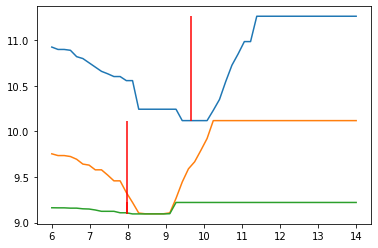

In [102]:
from my import multiple_opt_th

split = split_best
peak_ths = multiple_opt_th(S_t,th_range,split,UE_ANLs,UE_SCs,S_sc,cfg,info=True)

MAX PAPR before: 11.261
MAX PAPR after:  9.095
multiple thresholds
Thresholds: [9.66796875, 7.98046875, 7.98046875]
Sequential(
  (layer_0): reduction_layer(peak_th=9.668,group_ANL_th=0.006125)
  (layer_1): reduction_layer(peak_th=7.980,group_ANL_th=0.001664)
  (layer_2): reduction_layer(peak_th=7.980,group_ANL_th=0.000021)
)


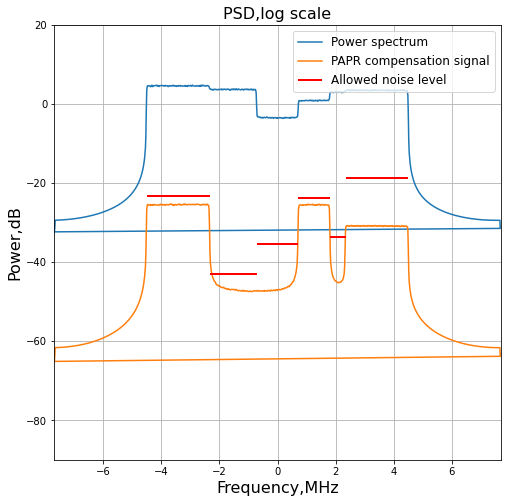

In [104]:
S_t_reduced =  test_reduction(S_t,split_best,peak_ths,UE_ANLs,UE_SCs,S_sc,cfg,info=True)

SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Power spectrum','PAPR compensation signal']
TITLE='PSD,log scale'
PSD=plots.plot_spectrum(SIGNALS,LABELS,TITLE,ANL_allocation,SCs,cfg,PSD_SIZE)

MAX PAPR before: 11.261
MAX PAPR after:  9.095
multiple thresholds
Thresholds: [9.66796875, 7.98046875, 7.98046875]
Sequential(
  (layer_0): reduction_layer(peak_th=9.668,group_ANL_th=0.006125)
  (layer_1): reduction_layer(peak_th=7.980,group_ANL_th=0.001664)
  (layer_2): reduction_layer(peak_th=7.980,group_ANL_th=0.000021)
)


NameError: name 'signal' is not defined

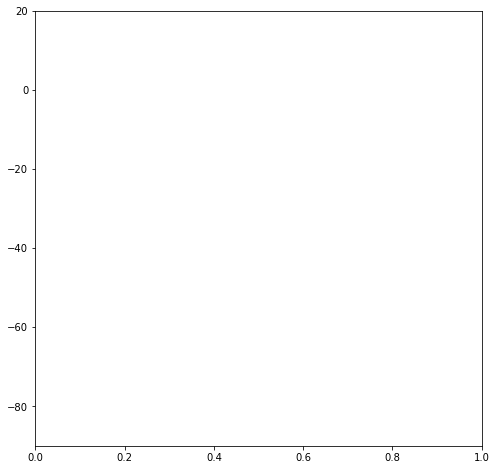

In [118]:
def plot_spectrum(SIGNALS,LABELS,TITLE,ANL_allocation,SC,config,figsize):
    assert len(SIGNALS)==len(LABELS)
    fontsize=16
    N_fft=config['N_fft']
    Fs=config['Fs']
    N_UE=config['N_UE']
    # create window
    # win = signal.get_window('hanning', N_fft)
#     win = np.ones(N_fft)
    # create figure
    plt.figure(figsize=figsize)
    plt.ylim(-90,20)
    G_ANLs = [np.min(ANL_allocation[ues]) for ues in split_best]
    # G_ANLs = [(ANL_allocation[ues]) for ues in split_best]
    # for item in G_ANLs:
    #     minim = np.min(item)
    #     for i in range(len(item)):
    #         item[i] = minim

    PSD = []
    for s_t,lab in zip(SIGNALS,LABELS):
        S_temp = np.array(s_t.T.reshape(1,-1).cpu())
        f, Pxxf = signal.welch(S_temp, Fs, window=win, noverlap=N_fft//2, nfft=N_fft, return_onesided=False,scaling='density')
        plt.plot(f, pow2db(np.fft.ifftshift(Pxxf.T)),label=lab)
        PSD.append(Pxxf)

    for i in range(3):
        allowed_level = 10*np.log10(G_ANLs[i])
        top_level = 10*np.log10(np.array(PSD[0])[0,SC[i]:SC[i+1]]).mean()
        plt.hlines(top_level + allowed_level,0,1024,colors='r',linewidth=2) # (Fs/1024)*SC[i]-Fs/2,(Fs/1024)*SC[i+1]-Fs/2
        # allowed_level = 10*np.log10(ANL_allocation[i])
        # top_level = 10*np.log10(np.array(PSD[0])[0,SC[i]:SC[i+1]]).mean()
        # if i == 0: plt.hlines(top_level + allowed_level,(Fs/1024)*SC[i]-Fs/2,(Fs/1024)*SC[i+1]-Fs/2,colors='r',linewidth=2,label='Allowed noise level')
        # else: plt.hlines(top_level + allowed_level,(Fs/1024)*SC[i]-Fs/2,(Fs/1024)*SC[i+1]-Fs/2,colors='r',linewidth=2)
        
#     for i in range(N_UE):
#         allowed_level = 10*np.log10(ANL_allocation[i])
#         top_level = 10*np.log10(np.array(PSD[0])[0,SC[i]:SC[i+1]]).mean()
#         if i == 0: plt.hlines(top_level + allowed_level,(Fs/1024)*SC[i]-Fs/2,(Fs/1024)*SC[i+1]-Fs/2,colors='r',linewidth=2,label='Allowed noise level')
#         else: plt.hlines(top_level + allowed_level,(Fs/1024)*SC[i]-Fs/2,(Fs/1024)*SC[i+1]-Fs/2,colors='r',linewidth=2)
# #         plt.hlines(top_level + allowed_level,-Fs/2,Fs/2,colors='k',linestyles='--',linewidth=1)
        
    plt.title(TITLE,fontsize=fontsize)
    plt.xlim(-Fs/2,Fs/2)
    plt.xlabel('Frequency,MHz',fontsize=fontsize)
    plt.ylabel('Power,dB',fontsize=fontsize)
    plt.grid()
    plt.legend(loc='upper right',fontsize=12) 
    plt.show()
    
    return PSD


S_t_reduced =  test_reduction(S_t,split_best,peak_ths,UE_ANLs,UE_SCs,S_sc,cfg,info=True)

SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Power spectrum','PAPR compensation signal']
TITLE='PSD,log scale'
PSD=plot_spectrum(SIGNALS,LABELS,TITLE,ANL_allocation,SCs,cfg,PSD_SIZE)

In [115]:
ANL_allocation[]

array([1.66400e-03, 2.10000e-05, 6.25000e-04, 3.36875e-03, 2.20500e-04,
       6.12500e-03])

In [114]:
G_ANLs = [(ANL_allocation[ues]) for ues in split_best]
for item in G_ANLs:
    minim = np.min(item)
    for i in range(len(item)):
        item[i] = minim
G_ANLs

[array([0.006125]),
 array([0.001664, 0.001664]),
 array([2.1e-05, 2.1e-05, 2.1e-05])]

# Sequential reduction
### Single threshold

PAPR after reduction:8.687, best threshold: 8.297

MAX PAPR before: 11.261
MAX PAPR after:  8.687
multiple thresholds
Thresholds: [8.296875, 8.296875, 8.296875, 8.296875, 8.296875, 8.296875]
Sequential(
  (layer_0): reduction_layer(peak_th=8.297,group_ANL_th=0.001664)
  (layer_1): reduction_layer(peak_th=8.297,group_ANL_th=0.000021)
  (layer_2): reduction_layer(peak_th=8.297,group_ANL_th=0.000625)
  (layer_3): reduction_layer(peak_th=8.297,group_ANL_th=0.003369)
  (layer_4): reduction_layer(peak_th=8.297,group_ANL_th=0.000221)
  (layer_5): reduction_layer(peak_th=8.297,group_ANL_th=0.006125)
)


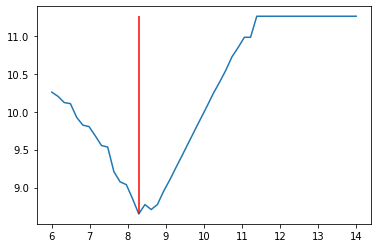

In [99]:
split_sequential = [np.array([i]) for i in range(cfg['N_UE'])]
split = split_sequential
best_th = single_opt_th(S_t,th_range,split,UE_ANLs,UE_SCs,S_sc,cfg,info=True)
peak_ths = [best_th]*cfg['N_UE']
S_t_reduced =  test_reduction(S_t,split,peak_ths,UE_ANLs,UE_SCs,S_sc,cfg,info=True)

### Multiple thresholds

PAPR after reduction:10.681, best threshold: 8.668

PAPR after reduction:10.631, best threshold: 8.668

PAPR after reduction:10.379, best threshold: 8.668

PAPR after reduction:9.923, best threshold: 8.668

PAPR after reduction:9.865, best threshold: 7.980

PAPR after reduction:9.191, best threshold: 7.980

PAPR after reduction:9.191, best thresholds: [8.66796875, 8.66796875, 8.66796875, 8.66796875, 7.98046875, 7.98046875]

MAX PAPR before: 11.261
MAX PAPR after:  9.191
multiple thresholds
Thresholds: [8.66796875, 8.66796875, 8.66796875, 8.66796875, 7.98046875, 7.98046875]
Sequential(
  (layer_0): reduction_layer(peak_th=8.668,group_ANL_th=0.001664)
  (layer_1): reduction_layer(peak_th=8.668,group_ANL_th=0.000021)
  (layer_2): reduction_layer(peak_th=8.668,group_ANL_th=0.000625)
  (layer_3): reduction_layer(peak_th=8.668,group_ANL_th=0.003369)
  (layer_4): reduction_layer(peak_th=7.980,group_ANL_th=0.000221)
  (layer_5): reduction_layer(peak_th=7.980,group_ANL_th=0.006125)
)


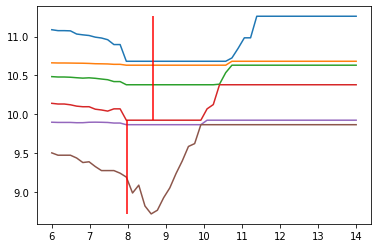

In [100]:
from my import multiple_opt_th

split = split_sequential
peak_ths = multiple_opt_th(S_t,th_range,split,UE_ANLs,UE_SCs,S_sc,cfg,info=True)
S_t_reduced =  test_reduction(S_t,split,peak_ths,UE_ANLs,UE_SCs,S_sc,cfg,info=True)

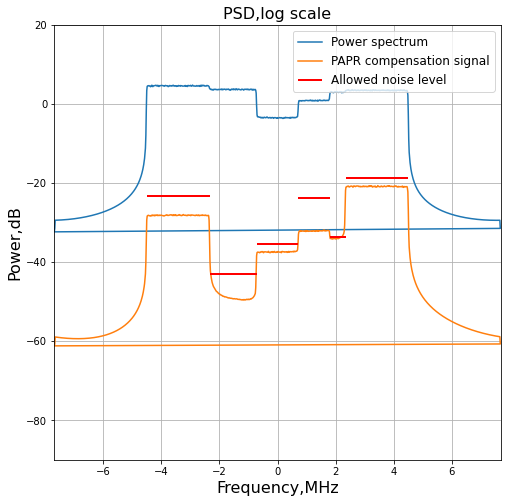

In [101]:
SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Power spectrum','PAPR compensation signal']
TITLE='PSD,log scale'
PSD=plots.plot_spectrum(SIGNALS,LABELS,TITLE,ANL_allocation,SCs,cfg,PSD_SIZE)

# OFDM signal generation

# Check PAPR

In [64]:
torch.cuda.ipc_collect()
torch.cuda.empty_cache()
D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False) # generate data points
S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=True) # modulate them
PAPR0 = syst.get_signal_PAPR(S_t) # find PAPR for each symbol
PAPR_mean0,PAPR_max0 = PAPR0.mean(),PAPR0.max()
max_PAPR_idx0 = torch.argmax(PAPR0)
print('Initial mean PAPR is ',PAPR_mean0)
print('Initial max PAPR is ',PAPR_max0)
print('Initial max PAPR symbol index ',max_PAPR_idx0)

The signal has been generated:
Total power =              170.667
OFDM symbols:                 1000
IFFT length:                 1024
Mean power in freq dommain = 17.380
Mean power in time dommain = 17.380
Initial mean PAPR is  tensor(8.6571, device='cuda:0')
Initial max PAPR is  tensor(11.7602, device='cuda:0')
Initial max PAPR symbol index  tensor(453, device='cuda:0')


# Max and min PAPR OFDM symbol

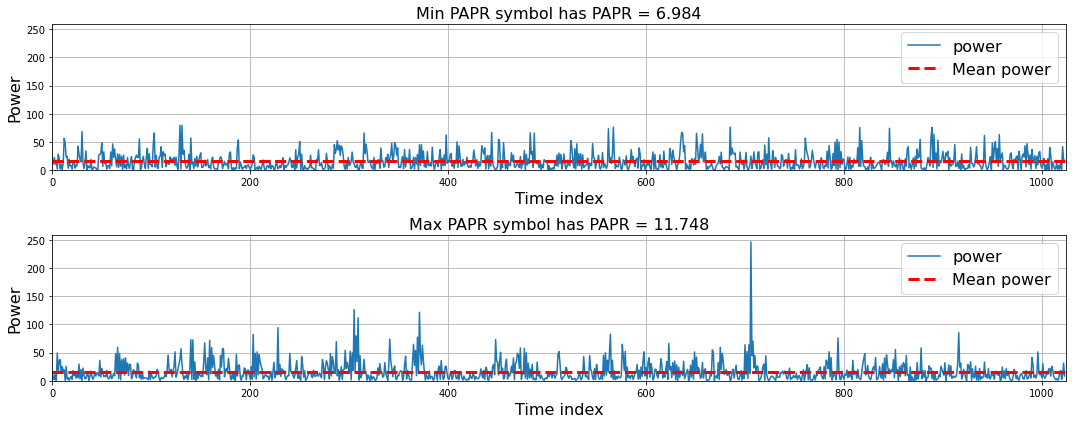

In [235]:
min_papr,max_papr = plots.find_max_min_papr_symbol(S_t,S_f,PAPR0)
plots.plot_maxminpapr(min_papr,max_papr,figsize=(15,6))

# PAPR probability density function (PDF)

In [236]:
# a = []
# for i in range(1000):
#     cfg['RNG_SEED'] = i
#     torch.cuda.ipc_collect()
#     torch.cuda.empty_cache()
#     D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False)
#     S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=False)
#     PAPR,PAPR_mean0,_ = syst.get_signal_PAPR(S_t)
#     a.extend(np.copy(PAPR.cpu()))

In [189]:
# bins = 300
# plt.figure(figsize=(12,3))
# plt.title('OFDM signal PAPR PDF',fontsize=16)
# plt.xlabel('PAPR value',fontsize=16)
# plt.ylabel('Probability',fontsize=16)

# h = plt.hist(np.array(a).reshape(-1,1)[:], bins, label='Signal amplitude')
# # plt.legend(loc='upper right', prop={'size': 14})
# plt.xlim(4,12)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.show()

# Clipping & filtering

MAX PAPR before: 11.594
MAX PAPR after:  11.348
multiple thresholds
Sequential(
  (layer_0): reduction_layer(peak_th=8.000,group_ANL_th=0.000028)
)


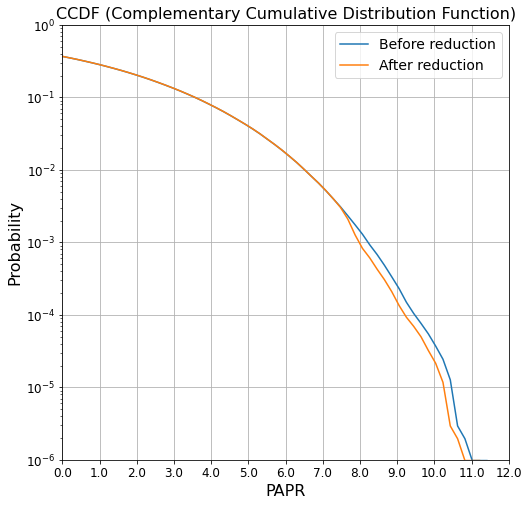

Mean PAPR before reduction: 8.656128883361816
Mean PAPR after reduction: 8.408291816711426
Max PAPR before reduction: 11.593658447265625
Max PAPR after reduction: 11.347838401794434


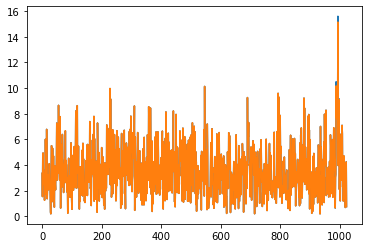

In [201]:
peak_ths = [8]
split = [np.arange(cfg['N_UE'])]
S_t_reduced = test_reduction(S_t,split,peak_ths,UE_ANLs,UE_SCs,S_sc,cfg,info=True)
PAPR0 = syst.get_signal_PAPR(S_t)
PAPR1 = syst.get_signal_PAPR(S_t_reduced)

LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDFs = [plots.filter_ccdf(CCDF1),plots.filter_ccdf(CCDF2)]
plots.plot_CCDF(CCDFs,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

print('Mean PAPR before reduction:',PAPR0.mean().item())
print('Mean PAPR after reduction:',PAPR1.mean().item())
print('Max PAPR before reduction:',PAPR0.max().item())
print('Max PAPR after reduction:',PAPR1.max().item())

idx = torch.argmax(PAPR0).item()
plt.plot(torch.abs(S_t[:,idx].cpu()))
plt.plot(torch.abs(S_t_reduced[:,idx].cpu()))

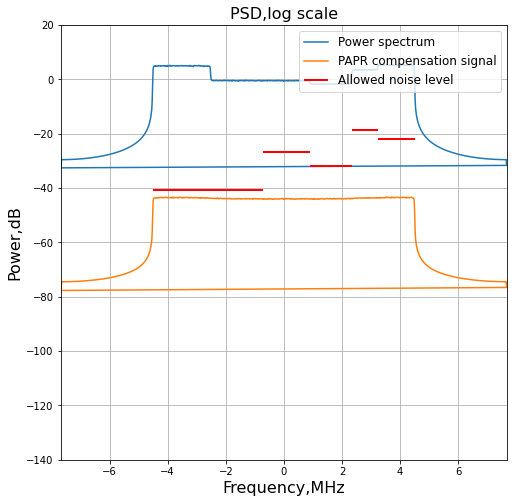

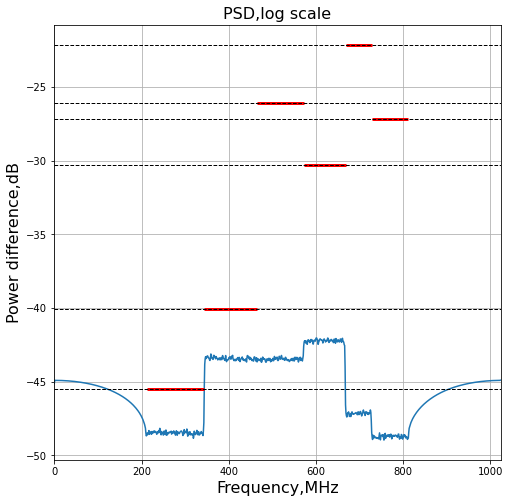

In [202]:
SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Power spectrum','PAPR compensation signal']
TITLE='PSD,log scale'
SC = syst.GET_UE_SC_idx(torch.tensor(RB_allocation))+ZERO_SHIFT
PSD=plots.plot_spectrum(SIGNALS,LABELS,TITLE,ANL_allocation,SC,cfg,PSD_SIZE)

In [342]:
# plt.plot(PSD[0].mean(axis=0))
# PSD[0].sum(axis=1)*(600/1024)**0.5
# PTX_allocation,PSD[0].mean(axis=0)[250:400].mean()*2.5,PSD[0].mean(axis=0)[500:550].mean(),PSD[0].mean(axis=0)[600:750].mean()

# All groups, different thresholds
# th = 4

MAX PAPR before: 11.594
MAX PAPR after:  11.329
single threshold
Sequential(
  (layer_0): reduction_layer(peak_th=4.000,group_ANL_th=0.006125)
  (layer_1): reduction_layer(peak_th=4.000,group_ANL_th=0.001920)
  (layer_2): reduction_layer(peak_th=4.000,group_ANL_th=0.000028)
)


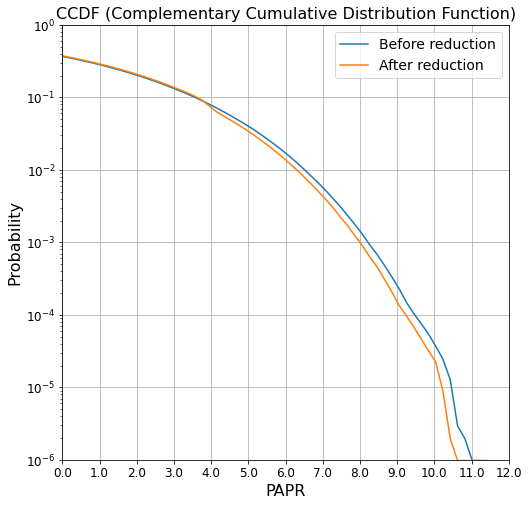

Mean PAPR before reduction: 8.656128883361816
Mean PAPR after reduction: 8.418807983398438
Max PAPR before reduction: 11.593658447265625
Max PAPR after reduction: 11.32858657836914


In [203]:
peak_ths = [4]
S_t_reduced = test_reduction(S_t,split_best,peak_ths,UE_ANLs,UE_SCs,S_sc,cfg,info=True)
PAPR0 = syst.get_signal_PAPR(S_t)
PAPR1 = syst.get_signal_PAPR(S_t_reduced)

LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDFs = [plots.filter_ccdf(CCDF1),plots.filter_ccdf(CCDF2)]
plots.plot_CCDF(CCDFs,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

print('Mean PAPR before reduction:',PAPR0.mean().item())
print('Mean PAPR after reduction:',PAPR1.mean().item())
print('Max PAPR before reduction:',PAPR0.max().item())
print('Max PAPR after reduction:',PAPR1.max().item())

# th = 6

MAX PAPR before: 11.594
MAX PAPR after:  11.079
single threshold
Sequential(
  (layer_0): reduction_layer(peak_th=6.000,group_ANL_th=0.006125)
  (layer_1): reduction_layer(peak_th=6.000,group_ANL_th=0.001920)
  (layer_2): reduction_layer(peak_th=6.000,group_ANL_th=0.000028)
)


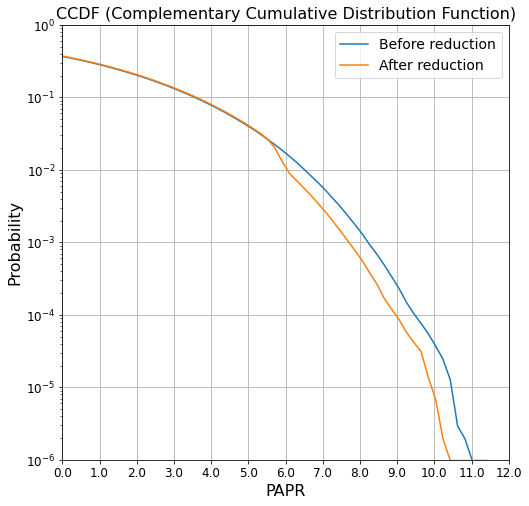

Mean PAPR before reduction: 8.656128883361816
Mean PAPR after reduction: 8.098111152648926
Max PAPR before reduction: 11.593658447265625
Max PAPR after reduction: 11.07933521270752


In [204]:
peak_ths = [6]
PAPR0 = syst.get_signal_PAPR(S_t)
S_t_reduced = test_reduction(S_t,split_best,peak_ths,UE_ANLs,UE_SCs,S_sc,cfg,info=True)
PAPR0 = syst.get_signal_PAPR(S_t)
PAPR1 = syst.get_signal_PAPR(S_t_reduced)

LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDFs = [plots.filter_ccdf(CCDF1),plots.filter_ccdf(CCDF2)]
plots.plot_CCDF(CCDFs,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

print('Mean PAPR before reduction:',PAPR0.mean().item())
print('Mean PAPR after reduction:',PAPR1.mean().item())
print('Max PAPR before reduction:',PAPR0.max().item())
print('Max PAPR after reduction:',PAPR1.max().item())

# th = 8

MAX PAPR before: 11.369
MAX PAPR after:  10.342
single threshold
Sequential(
  (layer_0): reduction_layer(peak_th=8.000,group_ANL_th=0.006125)
  (layer_1): reduction_layer(peak_th=8.000,group_ANL_th=0.001920)
  (layer_2): reduction_layer(peak_th=8.000,group_ANL_th=0.000028)
)


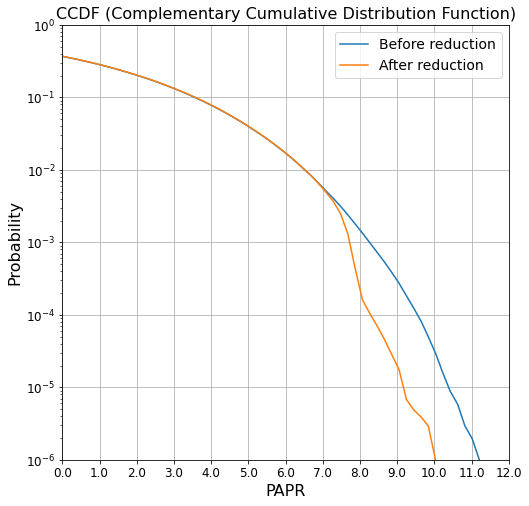

Mean PAPR before reduction: 8.686126708984375
Mean PAPR after reduction: 7.935943126678467
Max PAPR before reduction: 11.36859130859375
Max PAPR after reduction: 10.341777801513672


In [216]:
peak_ths = [8]
S_t_reduced = test_reduction(S_t,split_best,peak_ths,UE_ANLs,UE_SCs,S_sc,cfg,info=True)
PAPR0 = syst.get_signal_PAPR(S_t)
PAPR1 = syst.get_signal_PAPR(S_t_reduced)

LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDFs = [plots.filter_ccdf(CCDF1),plots.filter_ccdf(CCDF2)]
plots.plot_CCDF(CCDFs,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

print('Mean PAPR before reduction:',PAPR0.mean().item())
print('Mean PAPR after reduction:',PAPR1.mean().item())
print('Max PAPR before reduction:',PAPR0.max().item())
print('Max PAPR after reduction:',PAPR1.max().item())

tensor(224, device='cuda:0')
tensor(224, device='cuda:0')


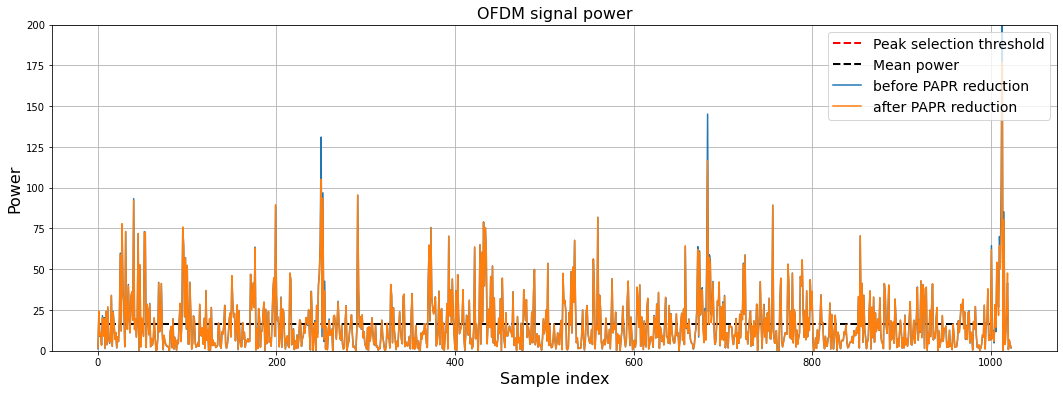

In [217]:
plt.figure(figsize=(18,6))
print(PAPR0.argmax())
print(PAPR1.argmax())
samples = 1024
idx = PAPR1.argmax().item()
peak_th = 0
plt.title('OFDM signal power',fontsize=16)
plt.hlines(np.mean(np.abs(np.array(S_t[2,:samples].cpu()))**2)*10**(peak_th/10),0,len(S_t[0,:samples]),'r','--',linewidth=2,label='Peak selection threshold')
plt.hlines(np.mean(np.abs(np.array(S_t[2,:samples].cpu()))**2),0,len(S_t[0,:samples]),'k','--',linewidth=2,label='Mean power')

stem = [True,False][1]
if stem:
    plt.stem(np.arange(samples),abs(S_t[:,idx].cpu())**2,markerfmt='',label='before PAPR reduction')
    plt.stem(np.arange(samples),abs(S_t_reduced[:,idx].cpu())**2,markerfmt='',label='after PAPR reduction')
else:
    plt.plot(abs(S_t[:samples,idx].cpu())**2,label='before PAPR reduction')
    plt.plot(abs(S_t_reduced[:samples,idx].cpu())**2,label='after PAPR reduction')

plt.ylim(0,200)
plt.legend(loc='upper right', prop={'size': 14})
plt.xlabel('Sample index',fontsize=16)
plt.ylabel('Power',fontsize=16)
plt.grid()

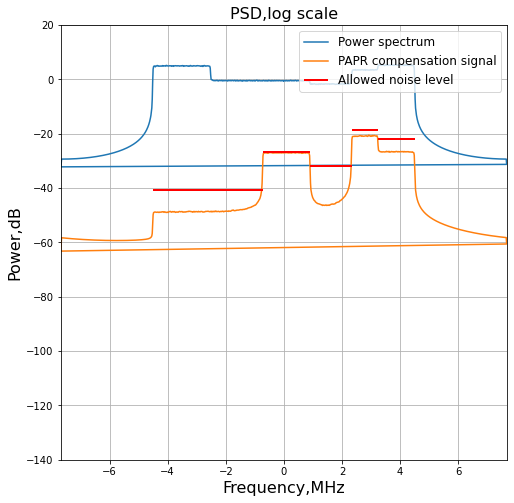

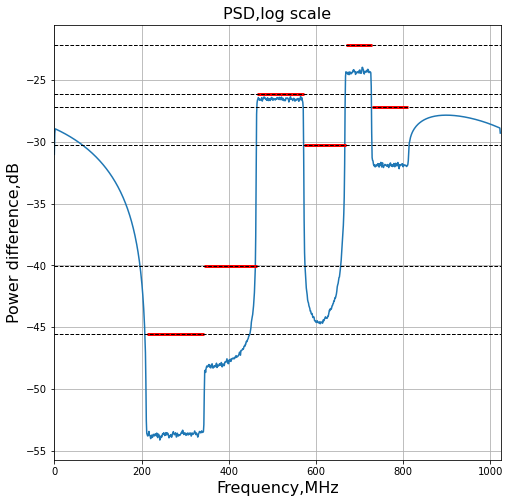

In [218]:
SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Power spectrum','PAPR compensation signal']
TITLE='PSD,log scale'
SC = syst.GET_UE_SC_idx(torch.tensor(RB_allocation))+ZERO_SHIFT
PSD=plots.plot_spectrum(SIGNALS,LABELS,TITLE,ANL_allocation,SC,cfg,PSD_SIZE)

# Several thresholds

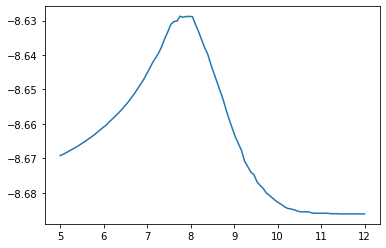

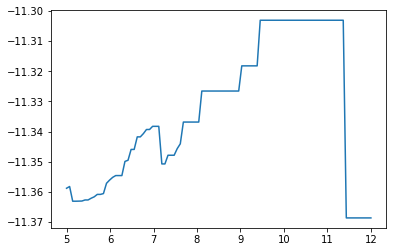

Opt th mean 7.757575757575758
Opt th max 9.454545454545453


TypeError: list indices must be integers or slices, not str

In [219]:
def find_opt_th1(S_t,ue_idx,th_range):
    """
    Finds optimal peak selection threshold for a given signal S_t on subcarriers for given user
    """
    res = {'mean':[],'max':[]}

    # find optimum
    for th in th_range:
        peak_th = th
        S_t_reduced = prd.PAPR_reduce(S_t,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)
        PAPR = syst.get_signal_PAPR(S_t_reduced)
        PAPR_mean = PAPR.mean().item()
        PAPR_max = PAPR.max().item()
        res['mean'].append(PAPR_mean)
        res['max'].append(PAPR_max)
    plt.plot(th_range,-np.array(res['mean']))
    plt.show()
    plt.plot(th_range,-np.array(res['max']))
    plt.show()
    return res

ue_idx=0
th_range = np.linspace(5,12,100)


res = find_opt_th1(S_t,ue_idx,th_range)
idx_mean = np.argmin(res['mean'])
print('Opt th mean',th_range[idx_mean])
idx_max = np.argmin(res['max'])
print('Opt th max',th_range[idx_max])
power = torch.abs(S_t)**2
power_mean = torch.sum(power,axis=0) / 1024
N = (power >= power_mean.reshape(1,-1)*10**(ths['max']/10)).sum()
print('The number of peaks (minimax)',N.item())


In [61]:
def find_opt_th(S_t,ue_idx,th_range):
    """
    Finds optimal peak selection threshold for a given signal S_t on subcarriers for given user
    """
    
    def reduce(S_t,peak_th):
        S_t_reduced = prd.PAPR_reduce(S_t,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)
        PAPR = syst.get_signal_PAPR(S_t_reduced)
        PAPR_mean = PAPR.mean()
        PAPR_max = PAPR.max()
        return PAPR_mean,PAPR_max
        
    ths = {'mean':0,'max':0}
    res = {'mean':[],'max':[]}
    
    bnd1 = np.array([th_range[0],th_range[-1]])
    # find optimum
    for i in range(10):
        mid_point1 = (bnd1[0] + bnd1[1])/2
        mid_res1,_ = reduce(S_t,mid_point1)
        mid_res1e11,_ = reduce(S_t,bnd1[0])
        mid_res1e12,_ = reduce(S_t,bnd1[1])
        edg_res1 = [mid_res1e11,mid_res1e12]
        # print(type(edg_res1[0].item()),type(edg_res1[1].item()),type(mid_res1.item()))
        idx_del1 = np.array([edg_res1[0].item(),edg_res1[1].item(),mid_res1.item()]).argmax()
        bnd1 = np.delete(np.array([bnd1[0],bnd1[1],mid_point1]),idx_del1)
        res['mean'].append(bnd1.mean().item())
    
    for th in th_range:
        peak_th = th
        S_t_reduced = prd.PAPR_reduce(S_t,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)
        PAPR = syst.get_signal_PAPR(S_t_reduced)
        PAPR_mean = PAPR.mean().item()
        PAPR_max = PAPR.max().item()
        res['max'].append(PAPR_max)
        
    ths['mean'] = bnd1.mean().item()
    ths['max'] = th_range[torch.argmin(torch.tensor(res['max']))]
    return ths

class function(torch.nn.Module):
    def __init__(self,peak_th,G_group_th,G_SC,S_sc,cfg):
        super(function, self).__init__()
        self.peak_th = peak_th
        self.G_group_th = G_group_th
        self.G_SC = G_SC
        self.S_sc = S_sc
        self.cfg = cfg
        
    def forward(self, S_t):
        S_t_reduced = prd.PAPR_reduce(S_t,self.peak_th,self.G_group_th,self.G_SC,self.S_sc,self.cfg,info=False)
        return S_t_reduced

    def extra_repr(self):
        return 'opt_th={}'.format(self.peak_th)

In [70]:
PERMUTATION = ['direct','random','descending_anl','contribution'][0]
if PERMUTATION == 'direct':
    UE_order = np.arange(cfg['N_UE'])
elif PERMUTATION == 'random':
    UE_order = np.random.permutation(np.arange(cfg['N_UE']))
elif PERMUTATION == 'descending_anl':
    UE_order = ANL_allocation.argsort()[::-1]
elif PERMUTATION == 'contribution':
    UE_order = (RB_allocation*ANL_allocation**0.5).argsort()[::-1]
print('permutation order: ',UE_order)

CRITERIA = ['mean','max'][1]

# create sequential container, add 1st layer
system = nn.Sequential()
# find optimal th for the 1st layer (user)
ue_idx = UE_order[0]
power = torch.abs(S_t)**2
power_mean = torch.sum(power,axis=0) / 1024
th = find_opt_th(S_t,ue_idx,th_range)
peak_th = th[CRITERIA]
N = (power >= power_mean.reshape(1,-1)*10**(th['max']/10)).sum()
print('The number of peaks (minimax)',N)

system.add_module('layer_'+str(0),function(peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg))

for i in range(1,cfg['N_UE']):
    ue_idx = UE_order[i]
    # find optimal threshold for the 2..end layer (user)
    S_t_reduced = system.forward(S_t)
    ths = find_opt_th(S_t_reduced,ue_idx,th_range)
    peak_th = th[CRITERIA]
    N = (power >= power_mean.reshape(1,-1)*10**(ths['max']/10)).sum()
    print('The number of peaks (minimax)',N)
    # add the 2nd..end layer
    system.add_module('layer_'+str(i),function(peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg))
# reduce via the last layer
S_t_reduced = system.forward(S_t)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean1 = PAPR.mean()
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')
print('Max PAPR reduction: ',PAPR_max0-PAPR[max_PAPR_idx0],'dB')
system.named_modules

permutation order:  [0 1 2 3 4 5]
The number of peaks (minimax) tensor(545, device='cuda:0')
The number of peaks (minimax) tensor(722, device='cuda:0')
The number of peaks (minimax) tensor(824, device='cuda:0')
The number of peaks (minimax) tensor(545, device='cuda:0')
The number of peaks (minimax) tensor(545, device='cuda:0')
The number of peaks (minimax) tensor(1921, device='cuda:0')
Mean PAPR before reduction: tensor(8.7022, device='cuda:0')
Mean PAPR after reduction: tensor(8.3388, device='cuda:0')
Mean PAPR has been reduced by:  tensor(0.3634, device='cuda:0') dB
Max PAPR reduction:  tensor(3.0004, device='cuda:0') dB


<bound method Module.named_modules of Sequential(
  (layer_0): function(opt_th=8.747474747474747)
  (layer_1): function(opt_th=8.747474747474747)
  (layer_2): function(opt_th=8.747474747474747)
  (layer_3): function(opt_th=8.747474747474747)
  (layer_4): function(opt_th=8.747474747474747)
  (layer_5): function(opt_th=8.747474747474747)
)>

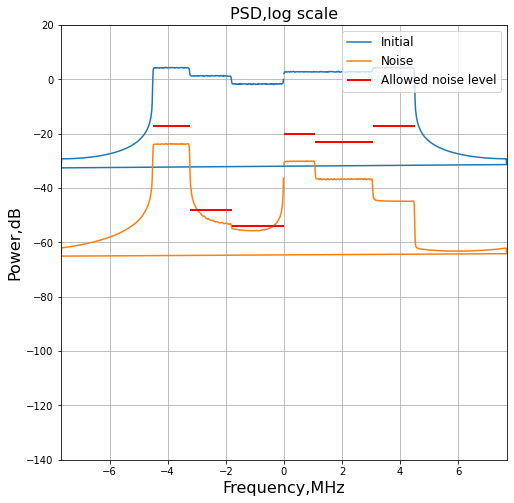

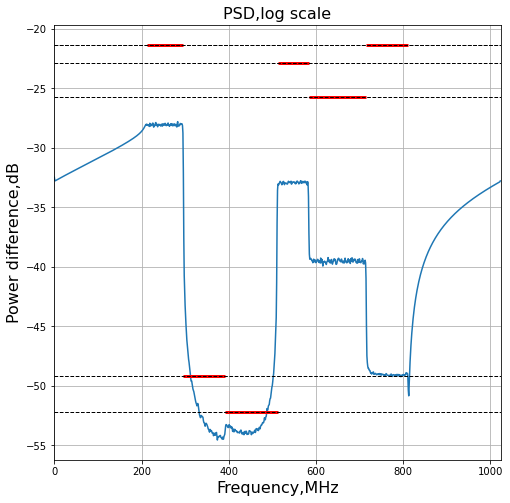

In [72]:
SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Initial','Noise']
TITLES='PSD,log scale'
SC = syst.GET_UE_SC_idx(torch.tensor(RB_allocation))+ZERO_SHIFT
PSD=plots.plot_spectrum(SIGNALS,LABELS,TITLE,ANL_allocation,SC,cfg,PSD_SIZE)

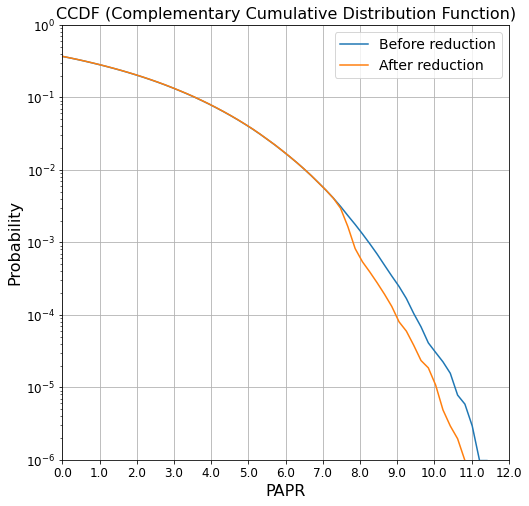

PAPR_mean before reduction tensor(8.6862, device='cuda:0')
PAPR_mean after reduction tensor(8.2141, device='cuda:0')
Mean PAPR has been reduced by:  tensor(0.4721, device='cuda:0')
Max PAPR reduction:  tensor(0.4791, device='cuda:0')


In [69]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDF = [CCDF1,CCDF2]

plots.plot_CCDF(CCDF,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean1 = PAPR.mean()
print('PAPR_mean before reduction',PAPR_mean0)
print('PAPR_mean after reduction',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1)
print('Max PAPR reduction: ',PAPR_max0-PAPR[max_PAPR_idx0])

# One threshold

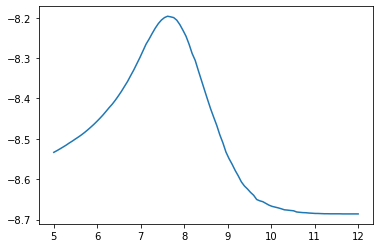

Threshold (minimean) 7.616161616161616
The number of peaks (minimax) tensor(691, device='cuda:0')


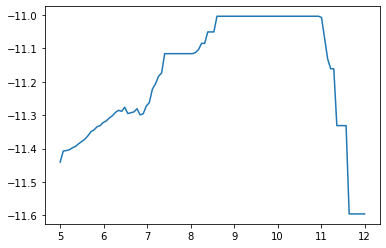

In [70]:
def find_opt_th2(S_t,th_range):
    ths = {'mean':0,'max':0}
    res = {'mean':[],'max':[]}

    for th in th_range:
        peak_th = th
        system = nn.Sequential()
        for i in range(cfg['N_UE']):
            ue_idx = UE_order[i]
            system.add_module('layer_'+str(i),function(peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg))
        S_t_reduced = system.forward(S_t)
        PAPR = syst.get_signal_PAPR(S_t_reduced)
        PAPR_mean = PAPR.mean().item()
        PAPR_max = PAPR.max().item()
        res['mean'].append(PAPR_mean)
        res['max'].append(PAPR_max)
    ths['mean'],ths['max'] = th_range[np.argmin(res['mean'])],th_range[np.argmin(res['max'])]
    plt.plot(th_range,-np.array(res['mean']))
    plt.show()
    plt.plot(th_range,-np.array(res['max']))
    return ths

power = torch.abs(S_t)**2
power_mean = torch.sum(power,axis=0) / 1024
th = find_opt_th2(S_t,th_range)
print('Threshold (minimean)',th['mean'])

N = (power >= power_mean.reshape(1,-1)*10**(th['max']/10)).sum()
print('The number of peaks (minimax)',N)

In [71]:
PERMUTATION = ['direct','random','descending_anl','contribution'][2]
if PERMUTATION == 'direct':
    UE_order = np.arange(cfg['N_UE'])
elif PERMUTATION == 'random':
    UE_order = np.random.permutation(np.arange(cfg['N_UE']))
elif PERMUTATION == 'descending_anl':
    UE_order = ANL_allocation.argsort()[::-1]
elif PERMUTATION == 'contribution':
    UE_order = (RB_allocation*ANL_allocation**0.5).argsort()[::-1]
print('permutation order: ',UE_order)

def find_opt_th(S_t,th_range):
    def reduce(S_t,peak_th):
        system = nn.Sequential()
        for i in range(cfg['N_UE']):
            ue_idx = UE_order[i]
            system.add_module('layer_'+str(i),function(peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg))
        S_t_reduced = system.forward(S_t)
        PAPR = syst.get_signal_PAPR(S_t_reduced)
        PAPR_mean = PAPR.mean().item()
        PAPR_max = PAPR.max().item()
        return PAPR_mean,PAPR_max

    ths = {'mean':0,'max':0}
    res = {'mean':[],'max':[]}
    th_range = np.linspace(4,10,201)

    bnd1 = np.array([th_range[0],th_range[-1]])

    for i in range(10):
        # find midddle point
        mid_point1 = (bnd1[0] + bnd1[1])/2
        mid_res1,_ = reduce(S_t,mid_point1)
        mid_res1e11,_ = reduce(S_t,bnd1[0])
        mid_res1e12,_ = reduce(S_t,bnd1[1])
        edg_res1 = [mid_res1e11,mid_res1e12]
        idx_del1 = np.array([edg_res1[0],edg_res1[1],mid_res1]).argmax()
        bnd1 = np.delete(np.array([bnd1[0],bnd1[1],mid_point1]),idx_del1)
        res['mean'].append(bnd1.mean().item())
    
    for th in th_range:
        peak_th = th
        S_t_reduced = prd.PAPR_reduce(S_t,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)
        PAPR = syst.get_signal_PAPR(S_t_reduced)
        PAPR_mean = PAPR.mean()
        PAPR_max = PAPR.max()
        res['max'].append(PAPR_max)
        
    ths['mean'] = bnd1.mean().item()
    ths['max'] = th_range[torch.argmin(torch.tensor(res['max']))]
    return ths

power = torch.abs(S_t)**2
power_mean = torch.sum(power,axis=0) / 1024
ths = find_opt_th(S_t,th_range)
print('Threshold (minimean)',th['mean'])

N = (power >= power_mean.reshape(1,-1)*10**(ths['max']/10)).sum()
print('The number of peaks (minimax)',N)

permutation order:  [3 1 5 2 0 4]
Threshold (minimean) 7.616161616161616
The number of peaks (minimax) tensor(708, device='cuda:0')


In [72]:
peak_th = ths[CRITERIA]
system = nn.Sequential()
for i in range(cfg['N_UE']):
    ue_idx = UE_order[i]
    system.add_module('layer_'+str(i),function(peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg))
S_t_reduced = system.forward(S_t)
PAPR = syst.get_signal_PAPR(S_t_reduced)

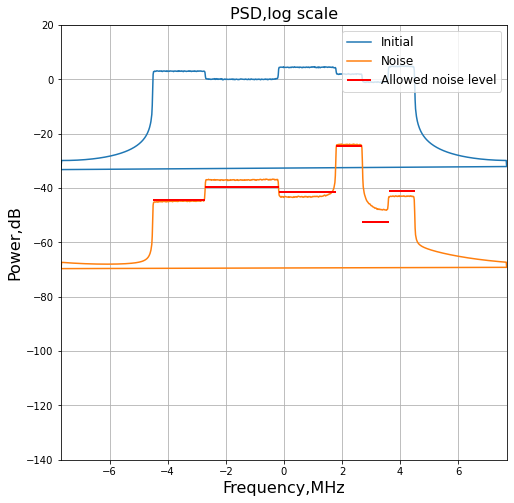

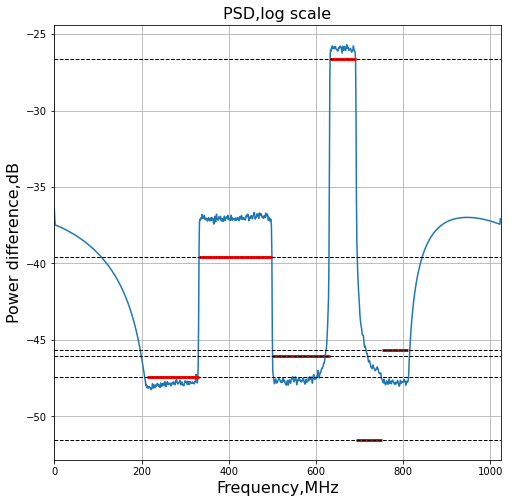

In [73]:
SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Initial','Noise']
TITLES='PSD,log scale'
PSD=plots.plot_spectrum(SIGNALS,LABELS,TITLE,ANL_allocation,SC,cfg,PSD_SIZE)

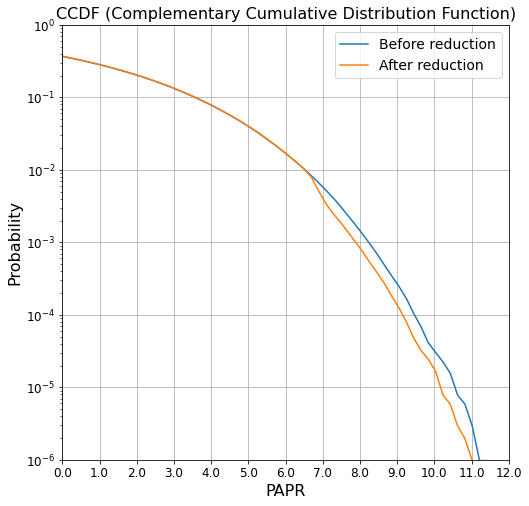

PAPR_mean before reduction tensor(8.6862, device='cuda:0')
PAPR_mean after reduction tensor(8.2947, device='cuda:0')
Mean PAPR has been reduced by:  tensor(0.3914, device='cuda:0')
Max PAPR reduction:  tensor(0.3237, device='cuda:0')


In [74]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDF = [CCDF1,CCDF2]

plots.plot_CCDF(CCDF,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean2 = PAPR.mean()

print('PAPR_mean before reduction',PAPR_mean0)
print('PAPR_mean after reduction',PAPR_mean2)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean2)
print('Max PAPR reduction: ',PAPR_max0-PAPR[max_PAPR_idx0])

# EXPERIMENT

In [49]:
# OPEN CONFIGURATION FILE
with open('config.yaml','r') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)
    print('Config has been readed successfully')

# edit configuration
# cfg['Fs'] = 15.36
cfg['N_UE'] = 2
# cfg['P_UE_max_min'] = 100
# cfg['N_fft'] = 300
# cfg['N_used'] = 120
# cfg['N_zero'] = 180
# cfg['N_RB'] = 10
cfg['M'] = 500
# cfg['N_SC_RB'] = 12

USE_SEED = False
if not USE_SEED:
    cfg['RNG_SEED'] = cfg['P_SEED'] = cfg['M_SEED'] = cfg['RB_SEED'] = None
else:
    cfg['RNG_SEED'], cfg['P_SEED'], cfg['M_SEED'], cfg['RB_SEED'] = 0,1,2,3
# show system's configuration
display(cfg)

# load complex and decimal modulation constellations
constellations = qmd.load_constellations(config=cfg,device=device,info=True)

# load Fourier matrix
S_sc = prd.gen_fourier_matrix(config=cfg,device=device)

# PAPR range for CCDF
PAPR_RANGE = torch.arange(0,12.2,step=0.2)

# zero shift to center spectrum
ZERO_SHIFT = cfg['N_zero']//2

CCDF_SIZE = (8,5)
PSD_SIZE = (10,6)

Config has been readed successfully


{'Fs': 15.36,
 'N_UE': 2,
 'P_UE_max_min': 100,
 'P_TX': 100,
 'N_fft': 1024,
 'N_used': 600,
 'N_zero': 424,
 'N_RB': 50,
 'EVM_QPSK': 17.5,
 'EVM_QAM16': 12.5,
 'EVM_QAM64': 8,
 'EVM_QAM256': 3.5,
 'EVM_QAM1024': 1,
 'M': 500,
 'N_SC_RB': 12,
 'RNG_SEED': None,
 'P_SEED': None,
 'M_SEED': None,
 'RB_SEED': None}

The following constelletions have been loaded: ['QPSK', 'QAM16', 'QAM64', 'QAM256', 'QAM1024']


In [39]:
torch.cuda.ipc_collect()
torch.cuda.empty_cache()
# generate data points
D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False)
# modulate them
S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=True)
# find mean PAPR
PAPR = syst.get_signal_PAPR(S_t)
PAPR_mean0 = PAPR.mean()
PAPR_max0 = PAPR.max()
max_PAPR_idx0 = torch.argmax(PAPR)
print('Initial mean PAPR is ',PAPR_mean0)
print('Initial max PAPR is ',PAPR_max0,max_PAPR_idx0)

The signal has been generated:
Total power =              100.693
OFDM symbols:                  500
IFFT length:                 1024
Mean power in freq dommain = 27.160
Mean power in time dommain = 27.160
Initial mean PAPR is  tensor(8.4752, device='cuda:0')
Initial max PAPR is  tensor(11.6697, device='cuda:0') tensor(90, device='cuda:0')


In [40]:
# evm_bounds = ((np.array([1,17.5])/100)**2)*(np.array([eps,100-eps])/np.array([eps,100-eps]).sum())
# evm_range = np.linspace(evm_bounds[0],evm_bounds[1],10)

p = 1
rb = 1
evm = 0
PTX_allocation = np.array([p,100-p])
EVM_allocation = np.array([evm,1])
ANL_allocation_P = ((EVM_allocation/100)**2)*(PTX_allocation/PTX_allocation.sum()) 
RB_allocation = np.array([rb,50-rb])
PTX_allocation,EVM_allocation,ANL_allocation_P,RB_allocation

UE_IDXs = np.arange(cfg['N_UE'])
UE_ANLs = ANL_allocation
UE_SCs = [syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=np.array([i]),RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT for i in UE_IDXs]

In [827]:
from tqdm import tqdm
eps = 1e-6
power_range = np.arange(0,101).astype(float)
power_range[0] += eps
power_range[-1] -= eps
rb_range = np.arange(1,50)
# evm_range = [1,3.5,8,12.5,17.5]
# mod_range = ['QAM1024','QAM256','QAM64', 'QAM16', 'QPSK']
evm_range = [3.5,8,12.5,17.5]
mod_range = ['QAM256','QAM64', 'QAM16', 'QPSK']

performance1 = np.zeros([len(power_range),len(rb_range),len(evm_range)])
performance2 = np.zeros([len(power_range),len(rb_range),len(evm_range)])

res = {'anl':[],'reduction_mean':[],'reduction_max':[],'rbs':[]}

for i,p in tqdm(enumerate(power_range)):
    for j,rb in enumerate(rb_range):
        for k,(evm,mod) in enumerate(zip(evm_range,mod_range)):
            # setup systems parameters
            PTX_allocation = np.array([p,100-p])
            k = 0
            EVM_allocation = np.array([evm,evm_range[k]])
            MOD_allocation = [mod,mod_range[k]]
            ANL_allocation_P,_ = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=False)
            ANL_allocation = ANL_allocation_P
            RB_allocation = np.array([rb,50-rb])
            
            torch.cuda.ipc_collect()
            torch.cuda.empty_cache()
            # generate data points
                # depends on modulation types
                # depends on resourse block allocation
            D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False)
            # modulate them
                # depends on modulation types
                # depends on power allocation
                # depends on resourse block allocation
            S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=False)
            # find mean PAPR
            PAPR = syst.get_signal_PAPR(S_t)
            PAPR_mean0 = PAPR.mean()
            PAPR_max0 = PAPR.max()
            
            # select group (user)
            ue = 0
            G0_UE_idx = np.array([ue])
            G0_ANL = ANL_allocation[ue]

            # select subcarriers for PAPR reduction
            G0_SC = syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=G0_UE_idx,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
            # generate group threshold
            G0_group_th = G0_ANL
            # choose peak selection thresold
            peak_th = 7.5
            # reduce PAPR
            S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G0_group_th,G0_SC,S_sc,cfg,info=False)
            # find mean PAPR
            PAPR = syst.get_signal_PAPR(S_t_reduced)
            PAPR_mean1 = PAPR.mean()
            PAPR_max1 = PAPR.max()
            reduction_mean = PAPR_mean0 - PAPR_mean1
            reduction_max = PAPR_max0 - PAPR_max1
            
            
            performance1[i,j,k] = reduction_mean
            performance2[i,j,k] = reduction_max
            
            res['anl'].append(G0_ANL)
            res['reduction_mean'].append(reduction_mean.item())
            res['reduction_max'].append(reduction_max.item())
            res['rbs'].append(rb)
#             print('ggg')
#             break
#         break
#     break
# PTX_allocation,EVM_allocation,ANL_allocation_P,RB_allocation

101it [08:08,  4.83s/it]


In [50]:
import h5py
# path = '2ue_th=7_5'
# with h5py.File(path, 'w') as f:
#     f.create_dataset('anl', data = np.array(res['anl']))
#     f.create_dataset('reduction_mean', data = np.array(res['reduction_mean']))
#     f.create_dataset('reduction_max', data = np.array(res['reduction_max']))
#     f.create_dataset('rbs', data = np.array(res['rbs']))

path = '2ue_th=6_5'
res1 = {'anl':None,'reduction_mean':None,'rbs':None,'reduction_max':None}
with h5py.File(path, 'r') as f:
    res1['anl'] = f['anl'][:]
    res1['reduction_mean'] = f['reduction_mean'][:]
    res1['reduction_max'] = f['reduction_max'][:]
    res1['rbs'] = f['rbs'][:]

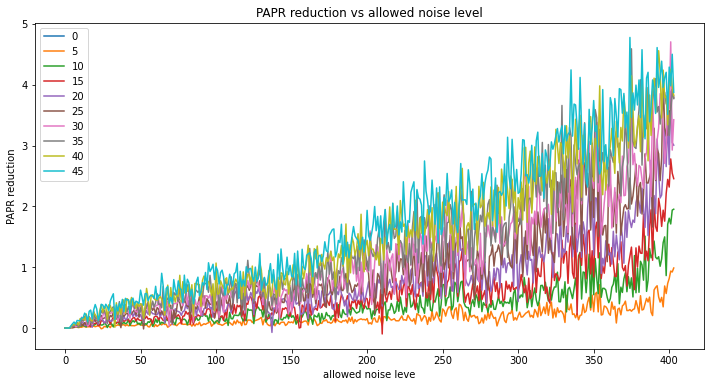

In [51]:
# i-th rb idxs

plt.figure(figsize=(12,6))
plt.title('PAPR reduction vs allowed noise level')
plt.xlabel('allowed noise leve')
plt.ylabel('PAPR reduction')

for i in range(10):
    lst = (res1['rbs'] == i*5)
    idxs = ([i for i, x in enumerate(lst) if x])
    # anl for these idxs
    ordering = res1['anl'][idxs].argsort()
    # reduction for these idxs and ordering
    paprd = res1['reduction_max'][idxs][ordering]
    plt.plot(paprd,label=str(5*i))
plt.legend()

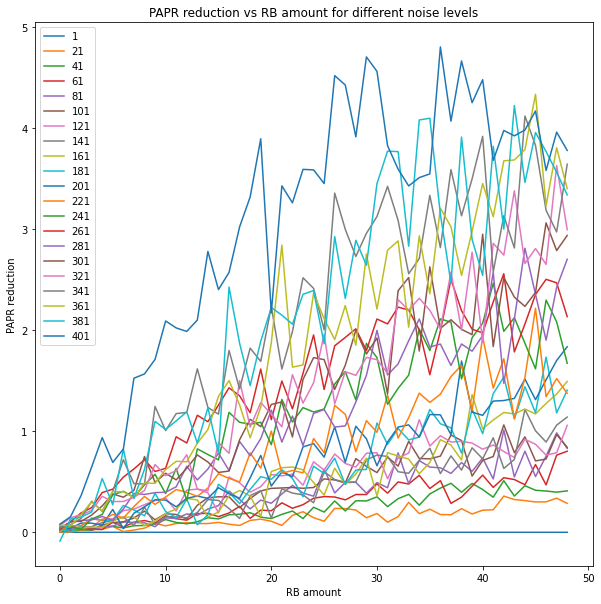

In [52]:
anls = np.sort(res1['anl'])
anls = np.unique(anls)
plt.figure(figsize=(10,10))
plt.title('PAPR reduction vs RB amount for different noise levels')
plt.xlabel('RB amount')
plt.ylabel('PAPR reduction')

for i in range(21):
    lst1 = res1['anl'] == anls[i*20+1]
    idxs1 = ([i for i, x in enumerate(lst1) if x])
    paprd = res1['reduction_max'][idxs1]
    plt.plot(paprd,label=str(20*i+1))

# plt.xlim(0,25)
# plt.ylim(0,1)

plt.legend()

# UE contribution: approximated and experiimental

$$ C \approx N_{RB} \cdot \sqrt{ANL} $$

* UE power has been allocated - OK:
Max UE power can be:     99.010
Min UE power can be:      0.990
Sum UE power can be:    100.000
Current Ptx allocation: [24. 76.] Sum = 100.000

* MODs have been allocated - OK:
Current MODs allocation: ['QPSK', 'QAM64']
Current EVMs allocation: [17.5  8. ]

Allowed noise level allocation: [-21.337 -23.13 ] dB
                                [8.573 6.974] %

* RBs have been allocated - OK:
Current RB allocation: [31 19] Sum = 50

The signal has been generated:
Total power =              170.667
OFDM symbols:                  500
IFFT length:                 1024
Mean power in freq dommain = 43.760
Mean power in time dommain = 43.760
contribution pred [1.         0.49859167]
contribution real [1.         0.05325098]


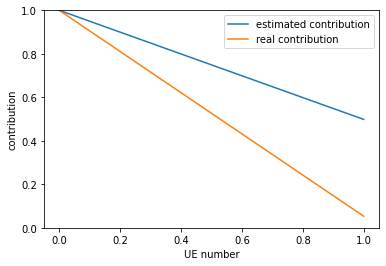

In [53]:
PTX_allocation = syst.PTX_allocate(config=cfg,info=True)
MOD_allocation,EVM_allocation = syst.MOD_allocate(config=cfg,info=True)
ANL_allocation_P,ANL_allocation_A = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=True)
ANL_allocation = ANL_allocation_P
RB_allocation = syst.RB_allocate(config=cfg,info=True)

torch.cuda.ipc_collect()
torch.cuda.empty_cache()
# generate data points
D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False)
# modulate them
S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=True)
# find mean PAPR
PAPR = syst.get_signal_PAPR(S_t)
PAPR_mean0 = PAPR.mean()
PAPR_max0 = PAPR.max()
peak_th = 8

papr_reduction = []
for i in range(cfg['N_UE']):
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    ue_idx = i
    S_t_reduced = prd.PAPR_reduce(S_t,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)
    PAPR = syst.get_signal_PAPR(S_t_reduced)
    PAPR_mean1 = PAPR.mean()
    PAPR_max1 = PAPR.max()
    papr_reduction.append((PAPR_mean0-PAPR_mean1).cpu().item())

contribution_predicted = RB_allocation * ANL_allocation**0.5 / max(RB_allocation * ANL_allocation**0.5)
print('contribution pred',contribution_predicted)
contribution_real = papr_reduction/np.array(papr_reduction).max()
print('contribution real',contribution_real)

plt.ylim(0,1)
plt.plot(contribution_predicted,label='estimated contribution')
plt.plot(contribution_real,label='real contribution')
plt.xlabel('UE number')
plt.ylabel('contribution')
plt.legend()

# Machine learning

In [54]:
# OPEN CONFIGURATION FILE
with open('config.yaml','r') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)
    print('Config has been readed successfully')

# edit configuration
# cfg['Fs'] = 15.36
cfg['N_UE'] = 3
# cfg['P_UE_max_min'] = 100
cfg['N_fft'] = 1024
cfg['N_used'] = 600
cfg['N_zero'] = 424
cfg['N_RB'] = 50
cfg['M'] = 1000
# cfg['N_SC_RB'] = 12

USE_SEED = False
if USE_SEED:
     cfg['RNG_SEED'], cfg['P_SEED'], cfg['M_SEED'], cfg['RB_SEED'] = 0,1,2,3 
else:
    cfg['RNG_SEED'] = cfg['P_SEED'] = cfg['M_SEED'] = cfg['RB_SEED'] = None
# show system's configuration
display(cfg)

# load complex and decimal modulation constellations
constellations = qmd.load_constellations(config=cfg,device=device,info=True)

# load Fourier matrix
S_sc = prd.gen_fourier_matrix(config=cfg,device=device)

# PAPR range for CCDF
PAPR_RANGE = torch.arange(0,12.2,step=0.2)

# zero shift to center spectrum
ZERO_SHIFT = cfg['N_zero']//2

CCDF_SIZE = (8,5)
PSD_SIZE = (10,6)

Config has been readed successfully


{'Fs': 15.36,
 'N_UE': 3,
 'P_UE_max_min': 100,
 'P_TX': 100,
 'N_fft': 1024,
 'N_used': 600,
 'N_zero': 424,
 'N_RB': 50,
 'EVM_QPSK': 17.5,
 'EVM_QAM16': 12.5,
 'EVM_QAM64': 8,
 'EVM_QAM256': 3.5,
 'EVM_QAM1024': 1,
 'M': 1000,
 'N_SC_RB': 12,
 'RNG_SEED': None,
 'P_SEED': None,
 'M_SEED': None,
 'RB_SEED': None}

The following constelletions have been loaded: ['QPSK', 'QAM16', 'QAM64', 'QAM256', 'QAM1024']


In [405]:
import pandas as pd
from tqdm import tqdm

def find_opt_th(S_t,th_range):
    def reduce(S_t,peak_th):
        system = nn.Sequential()
        for i in range(cfg['N_UE']):
            ue_idx = UE_order[i]
            system.add_module('layer_'+str(i),function(peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg))
        S_t_reduced = system.forward(S_t)
        PAPR = syst.get_signal_PAPR(S_t_reduced)
        PAPR_mean = PAPR.mean().item()
        PAPR_max = PAPR.max().item()
        return PAPR_mean,PAPR_max

    ths = {'mean':0,'max':0}
    res = {'mean':[],'max':[]}
#     th_range = np.linspace(4,10,201)

    bnd1 = np.array([th_range[0],th_range[-1]])

    for i in range(7):
        # find midddle point
        mid_point1 = (bnd1[0] + bnd1[1])/2
        mid_res1,_ = reduce(S_t,mid_point1)
        mid_res1e11,_ = reduce(S_t,bnd1[0])
        mid_res1e12,_ = reduce(S_t,bnd1[1])
        edg_res1 = [mid_res1e11,mid_res1e12]
        idx_del1 = np.array([edg_res1[0],edg_res1[1],mid_res1]).argmax()
        bnd1 = np.delete(np.array([bnd1[0],bnd1[1],mid_point1]),idx_del1)
        res['mean'].append(bnd1.mean().item())
    
    for th in th_range:
        peak_th = th
        S_t_reduced = prd.PAPR_reduce(S_t,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)
        PAPR = syst.get_signal_PAPR(S_t_reduced)
        PAPR_mean = PAPR.mean()
        PAPR_max = PAPR.max()
        res['max'].append(PAPR_max)
        
    ths['mean'] = bnd1.mean().item()
    ths['max'] = th_range[torch.argmin(torch.tensor(res['max']))]
    return ths

df0 = pd.DataFrame(columns=['N_UE',
                            'PTX_Allocation',
                            'RB_Allocation',
                            'MOD_Allocation',
#                             'MOD_Allocation_n',
#                             'ANL_Allocation',
#                             'Contribution',
                            'OPT_th_mean',
                            'OPT_th_max'])

th_range = np.linspace(6,10,21)

for i in tqdm(range(1000)):
#     perm = np.random.permutation(np.arange(3))
#     PTX_allocation = PTX_allocation = 100*np.ones(cfg['N_UE'])/cfg['N_UE']
#     PTX_allocation = np.array([20,30,50])[perm]
#     MOD_allocation = []
#     for i in range(3): MOD_allocation.append(['QAM256', 'QAM1024', 'QAM16'][perm[i]])
#     EVM_allocation = np.array([8,1,12.5])[perm]
#     RB_allocation = np.array([16,16,18])[perm]

    PTX_allocation = syst.PTX_allocate(config=cfg,info=False)
    MOD_allocation,EVM_allocation = syst.MOD_allocate(config=cfg,info=False)
    ANL_allocation,_ = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=False)
    RB_allocation = syst.RB_allocate(config=cfg,info=False)
#     Contribution = RB_allocation * ANL_allocation**0.5
    
    PERMUTATION = ['direct','random','descending_anl','contribution'][2]
    if PERMUTATION == 'direct':
        UE_order = np.arange(cfg['N_UE'])
    elif PERMUTATION == 'random':
        UE_order = np.random.permutation(UE_order)
    elif PERMUTATION == 'descending_anl':
        UE_order = ANL_allocation.argsort()[::-1]
    elif PERMUTATION == 'contribution':
        UE_order = (RB_allocation*ANL_allocation**0.5).argsort()[::-1]
# print('permutation order: ',UE_order)

    UE_IDXs = np.arange(cfg['N_UE'])
    UE_ANLs = ANL_allocation
    UE_SCs = [syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=np.array([i]),RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT for i in UE_IDXs]

    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()
    # generate data points
    D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False)
    # modulate them
    S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=False)
    # find mean PAPR before
    PAPR = syst.get_signal_PAPR(S_t)
    PAPR_mean0 = PAPR.mean()
    PAPR_max0 = PAPR.max()

    ths = find_opt_th(S_t,th_range)

    params_dict = {'N_UE':cfg['N_UE'],
                   'PTX_Allocation': np.array(PTX_allocation,dtype=int),
                   'RB_Allocation': RB_allocation,
                   'MOD_Allocation': MOD_allocation,
#                    'MOD_Allocation_n': MOD_allocation_n,
#                    'ANL_Allocation': ANL_allocation,
#                    'Contribution':Contribution,
                   'OPT_th_mean': ths['mean'],
                   'OPT_th_max': ths['max']}
    df0 = df0.append(params_dict,ignore_index=True)
df0

100%|██████████| 1000/1000 [13:18<00:00,  1.25it/s]


,N_UE,PTX_Allocation,RB_Allocation,MOD_Allocation,OPT_th_mean,OPT_th_max
0,3,"[31, 50, 19]","[21, 15, 14]","[QAM16, QAM256, QAM256]",6.890625,9.0
1,3,"[11, 74, 15]","[22, 10, 18]","[QAM64, QAM16, QAM256]",6.828125,9.2
2,3,"[17, 52, 31]","[16, 11, 23]","[QPSK, QAM256, QPSK]",6.265625,9.2
3,3,"[32, 43, 25]","[10, 14, 26]","[QAM64, QPSK, QPSK]",6.093750,9.0
4,3,"[62, 11, 27]","[18, 16, 16]","[QAM1024, QAM64, QPSK]",6.953125,9.6
...,...,...,...,...,...,...
995,3,"[11, 73, 16]","[17, 16, 17]","[QAM256, QAM64, QAM256]",6.953125,9.8
996,3,"[68, 25, 7]","[14, 23, 13]","[QAM64, QAM1024, QAM64]",7.234375,8.8
997,3,"[20, 60, 20]","[21, 21, 8]","[QPSK, QAM16, QAM256]",6.234375,9.4
998,3,"[67, 24, 9]","[12, 24, 14]","[QAM16, QAM16, QAM1024]",6.640625,8.2


In [55]:
# Save dataset
df0.to_csv('N=5_rep=1000.csv',sep='|')
df1 = pd.read_csv('N=5_rep=1000.csv',sep='|')
df1 = df0.copy(deep=True)
DATASET_SIZE = len(df1)
DATASET_SIZE

NameError: name 'df0' is not defined

In [407]:
# for i in range(DATASET_SIZE):
#     df1['PTX_Allocation'][i] = np.array(list(map(int, (df1['PTX_Allocation'][i])[1:-1].split(' ')[1:])))
#     df1['RB_Allocation'][i] = np.array(list(map(int, (df1['RB_Allocation'][i])[1:-1].split(' '))))
#     for i in (df1['MOD_Allocation'][i])[1:-1].split(','):
#         for mod in mod_list:
#             if mod in i:
#                 MOD_allocation.append(j)
#     df1['MOD_Allocation'][i] = MOD_allocation
# df1

    
    
# # PTX_allocation = np.array(list(map(int, (df1['PTX_Allocation'][0])[1:-1].split(' '))))
# # RB_allocation = np.array(list(map(int, (df1['RB_Allocation'][0])[1:-1].split(' '))))
# # MOD_allocation=[]
# # for i in (df1['MOD_Allocation'][0])[1:-1].split(','):
# #     for mod in mod_list:
# #         if mod in i:
# #             MOD_allocation.append(j)
# # MOD_allocation

In [927]:
X = df1[[
#          'N_UE',
         'PTX_Allocation',
         'RB_Allocation',
         'MOD_Allocation',
#          'MOD_Allocation_n',
#          'ANL_Allocation',
#          'OPT_th_mean',
#          'OPT_th_max']
        ]]
y_mean = df1['OPT_th_mean']
y_max = df1['OPT_th_max']

y = {'mean':y_mean,'max':y_max}

In [928]:
X[:3],y['mean'][:3],y['max'][:3]

(  PTX_Allocation RB_Allocation           MOD_Allocation
 0   [31, 50, 19]  [21, 15, 14]  [QAM16, QAM256, QAM256]
 1   [11, 74, 15]  [22, 10, 18]   [QAM64, QAM16, QAM256]
 2   [17, 52, 31]  [16, 11, 23]     [QPSK, QAM256, QPSK],
 0    6.890625
 1    6.828125
 2    6.265625
 Name: OPT_th_mean, dtype: float64,
 0    9.0
 1    9.2
 2    9.2
 Name: OPT_th_max, dtype: float64)

In [929]:
# encoding table
qpsk = np.array([1,0,0,0,0])
qam16 = np.array([0,1,0,0,0])
qam64 = np.array([0,0,1,0,0])
qam256 = np.array([0,0,0,1,0])
qam1024 = np.array([0,0,0,0,1])

def encode_modulation(item):
    out = []
    for i in item:
        if i == 0:
            out.append(qpsk)
        elif i == 1:
            out.append(qam16)
        elif i == 2:
            out.append(qam64)
        elif i == 3:
            out.append(qam256)
        elif i == 4:
            out.append(qam1024)
    return np.array(out)

mod_list = ['QPSK','QAM16','QAM64', 'QAM256','QAM1024']

def encode_input(X,idx):
    idxs = []
    for item in X['MOD_Allocation'][idx]:
        idxs.append(np.argmax(np.array(mod_list) == item))
    MOD_allocation_n = np.array(idxs)
    
    ANL = encode_modulation(MOD_allocation_n)
    PTX = X['PTX_Allocation'][idx].reshape(1,-1)/100
    RB = X['RB_Allocation'][idx].reshape(1,-1)/50
    X_encoded = np.hstack((ANL,PTX.T,RB.T)).flatten()
    return X_encoded

X1 = encode_input(X,idx=0)
for i in range(1,DATASET_SIZE):
    X1 = np.vstack((X1,encode_input(X,idx=i)))

# def encode_input1(X,idx):
#     ANL = encode_modulation(X['MOD_Allocation_n'][idx])
#     PTX = X['PTX_Allocation'][idx].reshape(1,-1)/100
#     RB = X['RB_Allocation'][idx].reshape(1,-1)/50
#     X_encoded = np.hstack((ANL.flatten(),PTX[0],RB[0]))
#     return X_encoded
# 
# X2 = encode_input1(X,idx=0)
# for i in range(1,DATASET_SIZE):
#     X2 = np.vstack((X2,encode_input1(X,idx=i)))

In [930]:
X1

array([[0.  , 1.  , 0.  , ..., 0.  , 0.19, 0.28],
       [0.  , 0.  , 1.  , ..., 0.  , 0.15, 0.36],
       [1.  , 0.  , 0.  , ..., 0.  , 0.31, 0.46],
       ...,
       [1.  , 0.  , 0.  , ..., 0.  , 0.2 , 0.16],
       [0.  , 1.  , 0.  , ..., 1.  , 0.09, 0.28],
       [0.  , 0.  , 0.  , ..., 0.  , 0.23, 0.32]])

In [986]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RANSACRegressor

CRITERIA = ['mean','max'][0]

X_train, X_test, y_train, y_test, idxs_train, idxs_test = train_test_split(X1, np.array(y[CRITERIA]).reshape(-1,), np.arange(DATASET_SIZE),test_size=0.33, random_state=0)
y_train[:5]

array([6.46875 , 6.984375, 6.515625, 7.359375, 7.140625])

In [987]:
idxs_train[0],df1.iloc[idxs_train[0]]

(863,
 N_UE                                     3
 PTX_Allocation                [18, 71, 11]
 RB_Allocation                 [14, 20, 16]
 MOD_Allocation    [QAM1024, QPSK, QAM1024]
 OPT_th_mean                        6.46875
 OPT_th_max                             9.2
 Name: 863, dtype: object)

In [988]:
reg = linear_model.LinearRegression(normalize=False)
reg.fit(X_train, y_train)
print('Score = ',reg.score(X_test,y_test))
y_perd = reg.predict(X_test)

Score =  0.8995529969555176


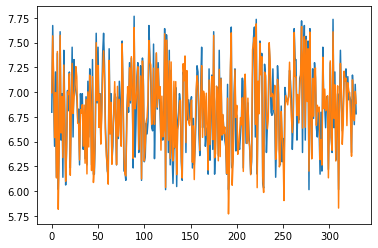

In [989]:
plt.plot(y_test)
plt.plot(y_perd)

In [990]:
reg = linear_model.Ridge(alpha=0.1,normalize=True,random_state=0)
reg.fit(X_train, y_train)
print('Score = ',reg.score(X_test,y_test))
y_perd = reg.predict(X_test)

Score =  0.8939200904324645


In [991]:
reg = linear_model.RidgeCV(normalize=False)
reg.fit(X_train, y_train)
print('Score = ',reg.score(X_test,y_test))
y_perd = reg.predict(X_test)

Score =  0.8997539831843842


In [992]:
reg = linear_model.Lasso(alpha=0.001,normalize=False,random_state=0)
reg.fit(X_train, y_train)
print('Score = ',reg.score(X_test,y_test))
y_perd = reg.predict(X_test)

Score =  0.8996041462895662


In [993]:
# scores = cross_val_score(reg, X1, y_mean, cv=5)
# scores.mean()

In [994]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
regr = MLPRegressor(hidden_layer_sizes=(3,),
                    activation='tanh',
                    solver='lbfgs',
                    alpha=0.1,
                    batch_size='auto',
                    learning_rate='constant',
                    learning_rate_init=0.01,
                    power_t=0.5, max_iter=1000,
                    shuffle=True,
                    random_state=0,
                    tol=0.00001,
                    verbose=False,
                    warm_start=False,
                    momentum=0.9,
                    nesterovs_momentum=True,
                    early_stopping=True,
                    validation_fraction=0.1,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=1e-08,
                    n_iter_no_change=10,
                    max_fun=1000)

regr.fit(X_train, y_train)
print('Score = ',regr.score(X_test,y_test))
y_perd = regr.predict(X_test)

scores = cross_val_score(regr, X_test, y_test, cv=5,)
scores.mean()

Score =  0.985408018141345


0.9819019664461885

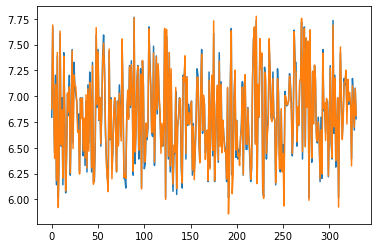

In [995]:
plt.plot(y_test)
plt.plot(y_perd)

In [997]:
def func(MOD_allocation,config):
    modulations = {}
    modulations['QPSK']=config['EVM_QPSK']
    modulations['QAM16']=config['EVM_QAM16']
    modulations['QAM64']=config['EVM_QAM64']
    modulations['QAM256']=config['EVM_QAM256']
    modulations['QAM1024']=config['EVM_QAM1024']
    EVM_allowed = np.zeros(len(MOD_allocation))
    for i,mod in enumerate(MOD_allocation):
        for mods in modulations.keys():
            if mod == mods:
                EVM_allowed[i] = modulations[mods]
    return EVM_allowed

PAPR_0 = {'max':[],'mean':[]}
PAPR_opt_th = {'max':[],'mean':[]}
PAPR_pred_th = {'max':[],'mean':[]}
print(CRITERIA)

for idx,th_pred in tqdm(zip(idxs_test,y_perd)):
    
    PTX_allocation = df1['PTX_Allocation'][idx] 
    MOD_allocation = df1['MOD_Allocation'][idx]
    EVM_allocation = func(MOD_allocation,cfg)
    ANL_allocation,_ = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=False)
    RB_allocation = df1['RB_Allocation'][idx]
    
    PERMUTATION = ['direct','random','descending_anl','contribution'][2]
    if PERMUTATION == 'direct':
        UE_order = np.arange(cfg['N_UE'])
    elif PERMUTATION == 'random':
        UE_order = np.random.permutation(UE_order)
    elif PERMUTATION == 'descending_anl':
        UE_order = ANL_allocation.argsort()[::-1]
    elif PERMUTATION == 'contribution':
        UE_order = (RB_allocation*ANL_allocation**0.5).argsort()[::-1]
#     print('permutation order: ',UE_order)

    UE_IDXs = np.arange(cfg['N_UE'])
    UE_ANLs = ANL_allocation
    UE_SCs = [syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=np.array([i]),RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT for i in UE_IDXs]

    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()
    # generate data points
    D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False)
    # modulate them
    S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=False)
    # find mean PAPR
    PAPR = syst.get_signal_PAPR(S_t)
    PAPR_mean0 = PAPR.mean().item()
    PAPR_max0 = PAPR.max().item()
    PAPR_0['mean'].append(PAPR_mean0)
    PAPR_0['max'].append(PAPR_max0)
    
    # optimal th from dataframe
    if CRITERIA == 'mean':
        peak_th = df1['OPT_th_mean'][idx] 
    elif CRITERIA == 'max':
        peak_th = df1['OPT_th_max'][idx] 
    
    system = nn.Sequential()
    for i in range(cfg['N_UE']):
        ue_idx = UE_order[i]
        system.add_module('layer_'+str(i),function(peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg))
    S_t_reduced1 = system.forward(S_t)
    PAPR = syst.get_signal_PAPR(S_t_reduced1)
    PAPR_mean1 = PAPR.mean().item()
    PAPR_max1 = PAPR.max().item()
    PAPR_opt_th['mean'].append(PAPR_mean1)
    PAPR_opt_th['max'].append(PAPR_max1)
    
    # predicted th  
    peak_th_pred = th_pred
    
    system = nn.Sequential()
    for i in range(cfg['N_UE']):
        ue_idx = UE_order[i]
        system.add_module('layer_'+str(i),function(peak_th_pred,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg))
    S_t_reduced2 = system.forward(S_t)
    PAPR = syst.get_signal_PAPR(S_t_reduced2)
    PAPR_mean2 = PAPR.mean().item()
    PAPR_max2 = PAPR.max().item()
    PAPR_pred_th['mean'].append(PAPR_mean2)
    PAPR_pred_th['max'].append(PAPR_max2)

0it [00:00, ?it/s]

mean


330it [00:35,  9.25it/s]


In [ ]:
CUSTOM = [True,False][1]
if CUSTOM:
    PTX_allocation = np.array([20,30,50])
    MOD_allocation = ['QPSK','QAM256','QAM256']
    EVM_allocation = func(MOD_allocation,cfg)
    ANL_allocation,_ = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=False)
    RB_allocation = np.array([30,15,5])
    print(PTX_allocation,MOD_allocation,RB_allocation)
else:
    idx = 329
    PTX_allocation = df1['PTX_Allocation'][idx] 
    MOD_allocation = df1['MOD_Allocation'][idx]
    EVM_allocation = func(MOD_allocation,cfg)
    ANL_allocation,_ = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=False)
    RB_allocation = df1['RB_Allocation'][idx]
    print(PTX_allocation,MOD_allocation,RB_allocation)
    
torch.cuda.ipc_collect()
torch.cuda.empty_cache()
# generate data points
D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False)
# modulate them
S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=False)
# find mean PAPR
PAPR = syst.get_signal_PAPR(S_t)
PAPR_mean0 = PAPR.mean().item()
PAPR_max0 = PAPR.max().item()
# PAPR_0['mean'].append(PAPR_mean0)
# PAPR_0['max'].append(PAPR_max0)
    
peak_th = 6.5
S_t_reduced_CAF = prd.PAPR_reduce(S_t,peak_th,np.min(ANL_allocation),np.arange(600)+ZERO_SHIFT,S_sc,cfg,info=False)

PAPR = syst.get_signal_PAPR(S_t_reduced1)
PAPR_mean1 = PAPR.mean().item()
PAPR_max1 = PAPR.max().item()
# PAPR_opt_th['mean'].append(PAPR_mean1)
# PAPR_opt_th['max'].append(PAPR_max1)

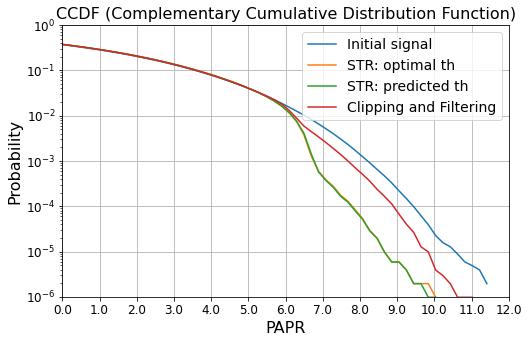

In [998]:
LABELS = ["Initial signal","STR: optimal th","STR: predicted th",'Clipping and Filtering']
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced1)
CCDF3 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced2)
CCDF4 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced_CAF)

CCDF = [CCDF1,CCDF2,CCDF3,CCDF4]

plots.plot_CCDF(CCDF,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

# PAPR = syst.get_signal_PAPR(S_t_reduced)
# PAPR_mean2 = PAPR.mean()

# print('PAPR_mean before reduction',PAPR_mean0)
# print('PAPR_mean after reduction',PAPR_mean2)
# print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean2)
# print('Max PAPR reduction: ',PAPR_max0-PAPR[max_PAPR_idx0])

In [ ]:
# OFDM signal amplitude probability distribution

# bins = 300
# plt.figure(figsize=(18,4))
# plt.title('PDF of OFDM signal',fontsize=16)
# plt.xlabel('Amplitude',fontsize=16)
# plt.ylabel('Probability',fontsize=16)

# signal = np.array(torch.abs(S_t).cpu().reshape(-1,1))

# h = plt.hist(signal, bins, label='Signal amplitude')
# plt.legend(loc='upper right', prop={'size': 14})
# plt.xlim(0,15)
# plt.show()

# bins = 300
# plt.figure(figsize=(18,4))
# plt.title('PDF of OFDM signal',fontsize=16)
# plt.xlabel('Amplitude',fontsize=16)
# plt.ylabel('Probability',fontsize=16)

# signal = np.array(torch.abs(S_t_reduced).cpu().reshape(-1,1))

# h = plt.hist(signal, bins, label='Signal amplitude')
# plt.legend(loc='upper right', prop={'size': 14})
# plt.xlim(0,15)
# plt.show()

In [ ]:
# sc=np.arange(len(S_t))
# plt.figure(figsize=(15,16))
# psd = -10*np.log10(PSD[0][0][sc])+10*np.log10(PSD[1][0][sc])
# plt.plot(psd,label = 'Difference: noise-signal')
# # plt.vlines(np.array([ZERO_SHIFT,ZERO_SHIFT+cfg['N_used']]),-50,10,colors='k',linewidth=0.5)
# for i in range(len(SC)-1):
#     plt.hlines(10*np.log10(ANL_allocation[i]),SC[i],SC[i+1],colors='r',linewidth=3,label = 'Allowed noise level')
    
# plt.ylabel('Noise level',fontsize=16)
# plt.xlabel('Subcarrier index',fontsize=16)
# plt.ylim(10*np.log10(ANL_allocation[i])-35,10*np.log10(ANL_allocation[i])+55)
# plt.legend(fontsize=16)
# plt.grid()

# print('Allowed EVM = ',10*np.log10(ANL_allocation[i]))
# print('Real    EVM = ',10*np.log10((torch.sum(torch.abs(S_t_reduced - S_t)**2)/torch.sum(torch.abs(S_t)**2)).cpu().item()))